In [1]:
import numpy as np
from tensorflow.keras.models import save_model, load_model, Model
from tensorflow.keras.layers import Input, Dropout, BatchNormalization, LeakyReLU, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv2DTranspose
import h5py 
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import segmentation_models as sm
import tensorflow.keras
# from tensorflow import keras
# from tensorflow.keras.layers import Input

Segmentation Models: using `keras` framework.


In [2]:
# 读取训练集
fh5 = h5py.File(r'E:\wujieyu\img train PolypGen+CVC\img Highlights processing FMM\imgandmasks_Highlights_processing_percentile=99.5.h5','r')
#fh5 = h5py.File(r'D:\PolypGen+CVCtrain_imgandmasks.h5','r')
img_png_x = fh5['img']
img_png_x = np.array(img_png_x)
#img_gray_c = fh5['img_gray']
#img_gray_c = np.array(img_gray_c)
mask_x = fh5['masks']
mask_x = np.array(mask_x)

In [3]:
img_png_x.shape

(2987, 288, 384, 3)

In [4]:
mask_x.shape

(2987, 288, 384)

In [5]:
img_png_x.max()

1.0

In [6]:
mask_x.max()

1.0

In [7]:
mask_x  = mask_x .reshape(len(mask_x),288, 384, 1)
mask_x .shape

(2987, 288, 384, 1)

In [8]:
# mask_x = mask_x/255

In [9]:
mask_x.max()

1.0

In [10]:
# 划分训练集与验证集
# 划分训练集与验证集
# 划分训练集与验证集
# T_img_png_x
# T_mask_x
# V_img
# V_mask

In [11]:
# -----------------------------------------------------------------
# 从txt文件读取并恢复为NumPy数组
# -----------------------------------------------------------------
# 读取

Train = np.loadtxt('D:\edge\Train.txt', dtype=int)

Val = np.loadtxt('D:\edge\Val.txt', dtype=int)

In [12]:
Train.shape

(2390,)

In [13]:
Val.shape

(597,)

In [14]:
# -----------------------------------------------------------------
# 按索引划分图像数据
# -----------------------------------------------------------------
# 划分训练集（T_img_png_x）和验证集（V_img）
T_img = img_png_x[Train]
V_img = img_png_x[Val]

T_mask = mask_x[Train]
V_mask = mask_x[Val]

In [15]:
print(  T_img.shape,
        V_img.shape,
        T_mask.shape,
        V_mask.shape)

(2390, 288, 384, 3) (597, 288, 384, 3) (2390, 288, 384, 1) (597, 288, 384, 1)


(-0.5, 383.5, 287.5, -0.5)

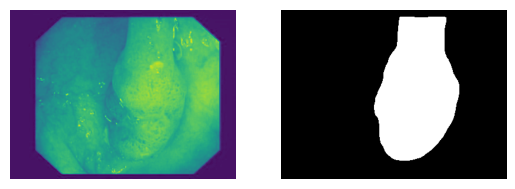

In [16]:
# 查看训练集集
a = 10
plt.figure()
plt.subplot(121),plt.imshow(T_img[a,:,:,0])
plt.axis('off')
plt.subplot(122),plt.imshow(T_mask[a],'gray')
plt.axis('off')

(-0.5, 383.5, 287.5, -0.5)

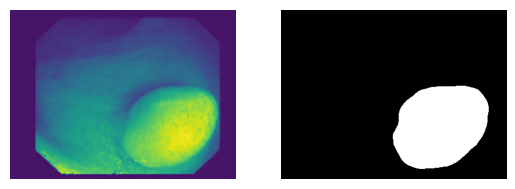

In [17]:
# 查看验证集
a = 10
plt.figure()
plt.subplot(121),plt.imshow(V_img[a,:,:,0])
plt.axis('off')
plt.subplot(122),plt.imshow(V_mask[a],'gray')
plt.axis('off')

In [2]:
BACKBONE = 'inceptionv3'##骨架

In [3]:
model = sm.FPN(BACKBONE, classes=1, activation="sigmoid")

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [5]:
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

In [22]:
import keras
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(  monitor='val_iou_score',  # 监控指标（默认：val_loss）
                                        factor=0.5,               # 学习率衰减系数（新学习率 = 旧学习率 * factor）
                                        patience=20,              # 等待 epoch 数无改善后触发
                                        mode='max'              # 监控指标方向：'auto'/'min'/'max'（自动检测最大/最小化）
                                        # min_delta=0.0001,         # 视为“改善”的最小变化阈值
                                        # cooldown=0,               # 触发后暂停监控的 epoch 数（防止频繁调整）
                                        # min_lr=0                  # 学习率下限（避免过小导致训练停滞）
                                     ),

    
    keras.callbacks.ModelCheckpoint(filepath=r'E:\wujieyu\IoU best\FPN+V3\FMM+percentile=99.5（2）\img_FMM+percentile99.5_bestweigh_epoch_{epoch:03d}_val_iou_{val_iou_score:.4f}.h5', 
                                    # 保存路径（支持 epoch 变量，如 model_{epoch:02d}.h5）
                                    monitor='val_iou_score',
                                    save_best_only=True,           # 只保留最优模型
                                    save_weights_only=True,       # 若为 True 只保存权重，否则保存完整模型
                                    mode='max'                   # 监控指标方向（与 ReduceLROnPlateau 相同）
                                   )   ##保存最佳模型
                                      
    #keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto', 
                                  #baseline=None, restore_best_weights=False)
    ]

In [23]:

# 模型训练
model.fit(
       x=T_img,
       y=T_mask,
       # validation_split=0.2,  # 验证集
       batch_size=2,
       epochs=300,
       validation_data=(V_img, V_mask),
       callbacks = callbacks_list
)

Epoch 1/300
1195/1195 [==============================] - 89s 66ms/step - loss: 0.9852 - iou_score: 0.2878 - val_loss: 1.1795 - val_iou_score: 0.3192 - lr: 0.0010
Epoch 2/300
1195/1195 [==============================] - 79s 66ms/step - loss: 0.8166 - iou_score: 0.4206 - val_loss: 0.8807 - val_iou_score: 0.3946 - lr: 0.0010
Epoch 3/300
1195/1195 [==============================] - 78s 65ms/step - loss: 0.7030 - iou_score: 0.5082 - val_loss: 0.6176 - val_iou_score: 0.5528 - lr: 0.0010
Epoch 4/300
1195/1195 [==============================] - 77s 65ms/step - loss: 0.6567 - iou_score: 0.5381 - val_loss: 1.0267 - val_iou_score: 0.3961 - lr: 0.0010
Epoch 5/300
1195/1195 [==============================] - 78s 65ms/step - loss: 0.6061 - iou_score: 0.5741 - val_loss: 0.5942 - val_iou_score: 0.5682 - lr: 0.0010
Epoch 6/300
1195/1195 [==============================] - 77s 65ms/step - loss: 0.5613 - iou_score: 0.6068 - val_loss: 0.6196 - val_iou_score: 0.5317 - lr: 0.0010
Epoch 7/300
1195/1195 [=====

In [84]:
model.save_weights(r'E:\wujieyu\IoU best\FPN\FMM+percentile=99.5（1）\300img_FMM+percentile=99.5_weigh.h5')
# #路径文件名

In [5]:
# 读取测试集
fh5 = h5py.File(r'E:\wujieyu\img test\TestDataset\CVC-ColonDB\images\test_CVC-ColonDB_imgandmasks.h5','r')
#fh5 = h5py.File(r'D:\PolypGen+CVCtrain_imgandmasks.h5','r')
img_png_c = fh5['img']
img_png_c = np.array(img_png_c)
mask_c = fh5['masks']
mask_c = np.array(mask_c)

In [6]:
img_png_c.max()

1.0

In [7]:
mask_c=mask_c/255

In [8]:
mask_c[1].max()

1.0

In [9]:
# 读取测试集
fh5 = h5py.File(r'E:\wujieyu\img test\TestDataset\CVC-ColonDB\img Highlights processing FMM\test_CVC-ColonDB_imgandmasks_Highlights_percentile=99.5.h5','r')
#fh5 = h5py.File(r'D:\PolypGen+CVCtrain_imgandmasks.h5','r')
img_png_c1 = fh5['img']
img_png_c1 = np.array(img_png_c1)
mask_c1 = fh5['masks']
mask_c1 = np.array(mask_c1)

In [10]:
img_png_c1.max()

1.0

In [11]:
# mask_c = mask_c/255

In [12]:
mask_c1[1].max()

1.0

(-0.5, 383.5, 287.5, -0.5)

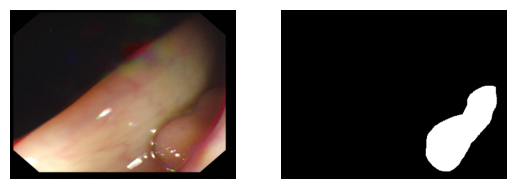

In [13]:
a = 10
plt.figure()
plt.subplot(121),plt.imshow(img_png_c[a])
plt.axis('off')
plt.subplot(122),plt.imshow(mask_c[a],'gray')
plt.axis('off')

(-0.5, 383.5, 287.5, -0.5)

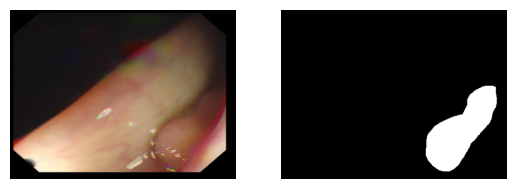

In [14]:
a = 10
plt.figure()
plt.subplot(121),plt.imshow(img_png_c1[a])
plt.axis('off')
plt.subplot(122),plt.imshow(mask_c1[a],'gray')
plt.axis('off')

In [22]:
import tensorflow as tf

def bce_jaccard_loss(y_true, y_pred, smooth=1e-7, alpha=0.5):
    """
    参数说明：
    - y_true: 真实标签 (shape=[batch, H, W, 1])
    - y_pred: 模型预测值 (shape=[batch, H, W, 1])
    - smooth: 防止除零的小常数
    - alpha: 平衡 BCE 和 Jaccard 的权重（默认 0.5）
    """
    # 计算二元交叉熵
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # 计算 Jaccard Loss (IoU Loss)  
    y_true_f = tf.keras.backend.flatten(y_true)   # 展平为向量 [batch*H*W]
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f + y_pred_f) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    jaccard_loss = 1 - jaccard  # 将 IoU 转换为 Loss
    
    # 加权组合
    return alpha * bce + (1 - alpha) * jaccard_loss

In [23]:
def dice_score(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    denominator = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return (2.0 * intersection + smooth) / (denominator + smooth)

In [24]:
# def iou_score(y_true, y_pred, smooth=1e-7):
#     y_true_f = tf.keras.backend.flatten(y_true)
#     y_pred_f = tf.keras.backend.flatten(y_pred)
#     intersection = tf.reduce_sum(y_true_f * y_pred_f)
#     union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
#     return (intersection + smooth) / (union + smooth)

In [25]:
model.compile(
    optimizer='Adam',
    loss=bce_jaccard_loss,  # 可替换为 iou_loss 或 bce_jaccard_loss
    metrics=[
        dice_score, 
        sm.metrics.iou_score
        # tf.keras.metrics.BinaryAccuracy()  # 可选：添加准确率指标
    ]
)

In [19]:
# # 加载模型
model.load_weights(r'E:\wujieyu\IoU best\FPN+V3\img\img_bestweigh_epoch_155_val_iou_0.7688.h5', by_name=True)

In [53]:
# 原图评估模型（返回 loss + metrics）
results = model.evaluate(img_png_c, mask_c, verbose=0)

In [54]:
# 打印所有指标名称和值
print("\n=== 测试结果 ===")
print(f"Loss: {results[0]:.4f}")
print(f"dice_score: {results[1]:.4f}")
print(f"iou_score: {results[2]:.4f}")


=== 测试结果 ===
Loss: 0.4679
dice_score: 0.7392
iou_score: 0.6256


In [55]:
# # 加载模型
model.load_weights(r'E:\wujieyu\IoU best\FPN+V3\FMM+percentile=99.5\img_FMM+percentile99.5_bestweigh_epoch_083_val_iou_0.7513.h5', by_name=True)

In [56]:
# 新方法评估模型（返回 loss + metrics）
results1 = model.evaluate(img_png_c1, mask_c1, verbose=0)

In [57]:
# 打印所有指标名称和值
print("\n=== 测试结果 ===")
print(f"Loss: {results1[0]:.4f}")
print(f"dice_score: {results1[1]:.4f}")
print(f"iou_score: {results1[2]:.4f}")


=== 测试结果 ===
Loss: 0.3170
dice_score: 0.7757
iou_score: 0.6618


In [15]:
# # 加载模型
model.load_weights(r'E:\wujieyu\IoU best\FPN+V3\img\img_bestweigh_epoch_155_val_iou_0.7688.h5', by_name=True)

In [16]:
#测试mask
imgp = model.predict(img_png_c, verbose=1)

12/12 [==============================] - 15s 551ms/step


In [17]:
# # 加载模型
model.load_weights(r'E:\wujieyu\IoU best\FPN+V3\FMM+percentile=99.5\img_FMM+percentile99.5_bestweigh_epoch_083_val_iou_0.7513.h5', by_name=True)

In [18]:
#测试mask
imgp1 = model.predict(img_png_c1, verbose=1)

12/12 [==============================] - 2s 169ms/step


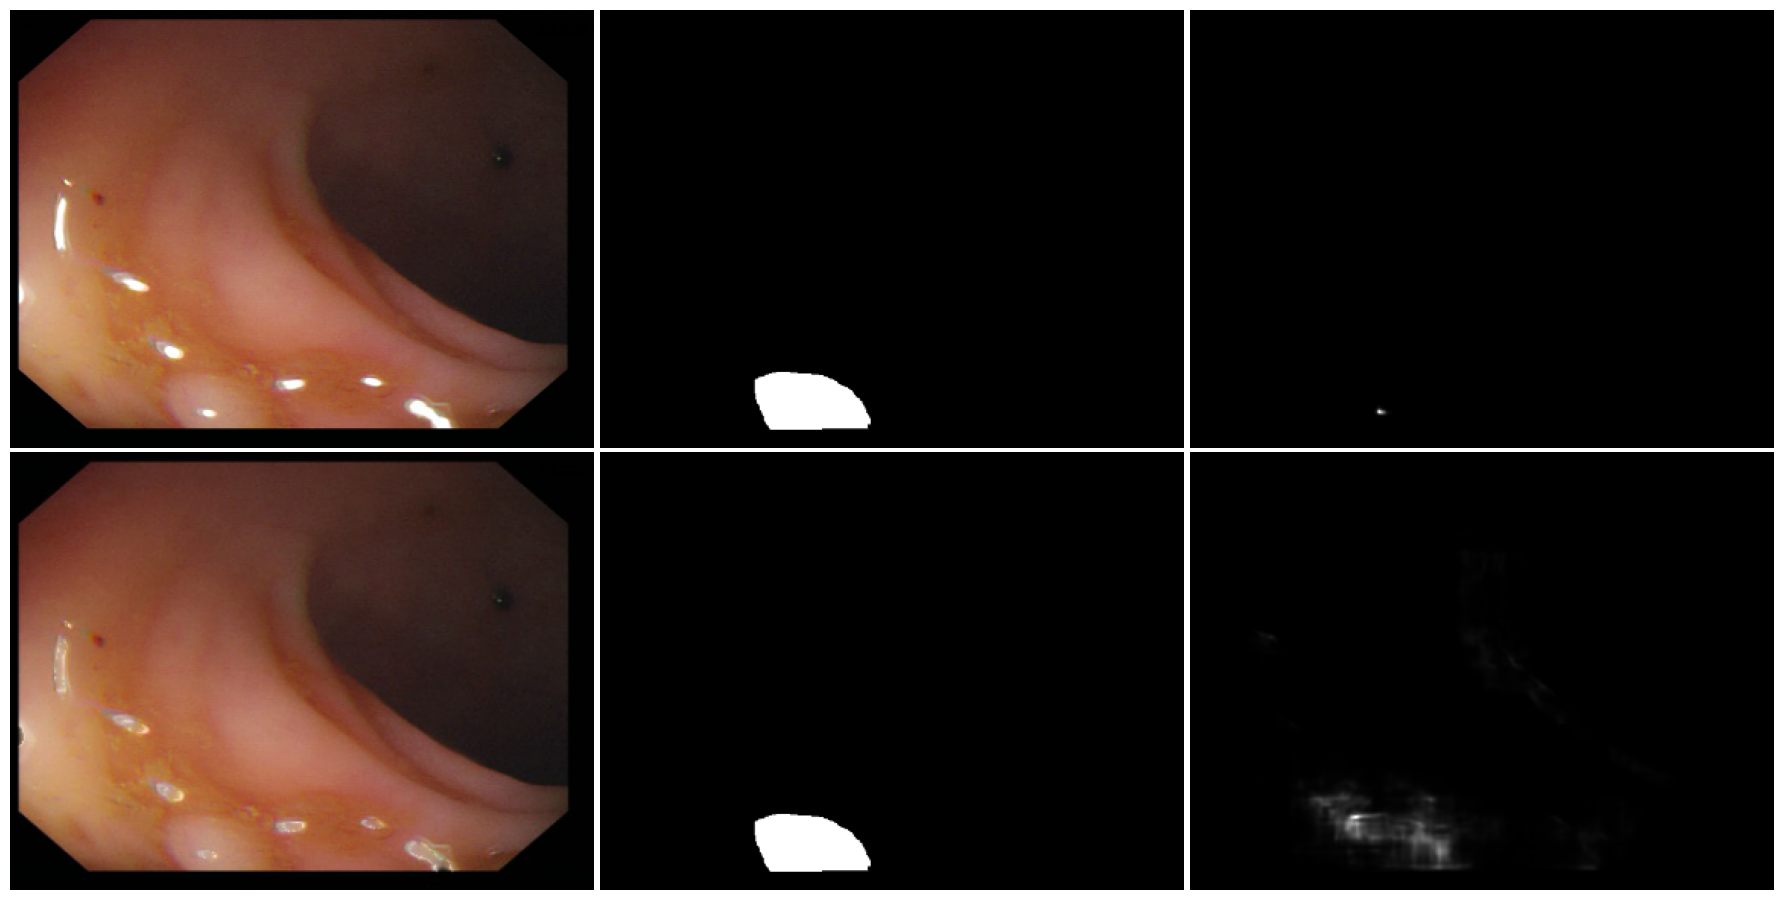

In [19]:
a = 1

# 设置适合2x3布局的画布尺寸
plt.figure(figsize=(18, 10))  # 宽度增加以适应3列，高度适当
plt.subplots_adjust(wspace=0.01,  # 列间距稍大于原设置
                    hspace=0.01,   # 行间距
                    left=0.01, 
                    right=0.99, 
                    top=0.93,     # 调整顶部留白
                    bottom=0.05)

# 第一行
plt.subplot(2,3,1)
plt.imshow(img_png_c[a])
plt.axis('off')
plt.subplot(2,3,2)
plt.imshow(mask_c[a], 'gray')
plt.axis('off')
plt.subplot(2,3,3)
plt.imshow(imgp[a].reshape(288, 384), cmap='gray')
plt.axis('off')
# 第二行
plt.subplot(2,3,4)
plt.imshow(img_png_c1[a], cmap='gray')
plt.axis('off')
plt.subplot(2,3,5)
plt.imshow(mask_c[a].reshape(288, 384), cmap='gray')
plt.axis('off')
plt.subplot(2,3,6)
plt.imshow(imgp1[a].reshape(288, 384), cmap='gray')
plt.axis('off')
plt.show()

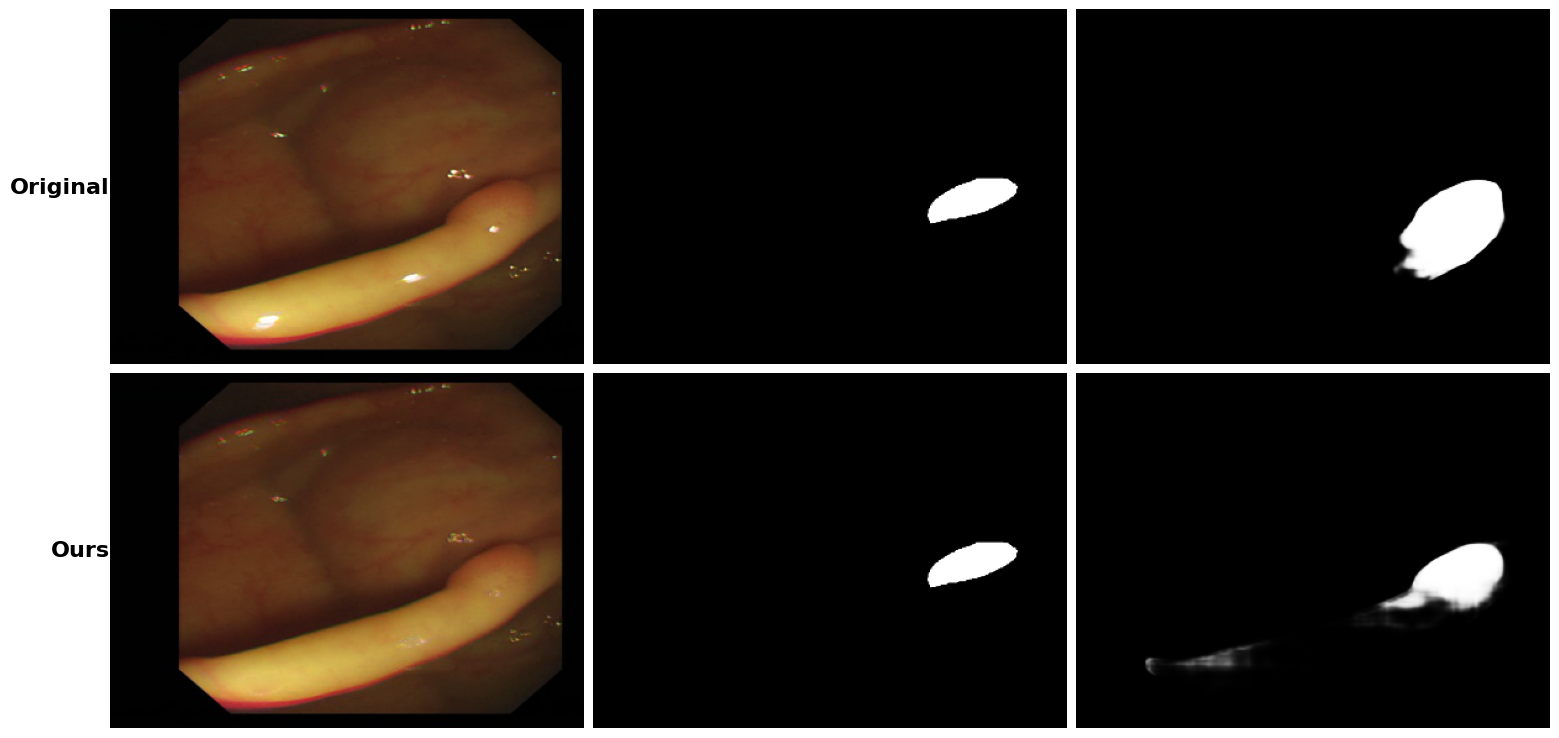

In [22]:
a = 117
# 创建画布并调整布局参数
plt.figure(figsize=(18, 9))
plt.subplots_adjust(wspace=0.02,
                    hspace=0.02,
                    left=0.12,    # 左侧留出行标题空间
                    right=0.92,
                    top=0.88,     # 顶部留出列标题空间
                    bottom=0.08)

fig = plt.gcf()

# ====== 精确计算坐标系统 ======
# 获取子图排列参数
nrows, ncols = 2, 3
grid = plt.GridSpec(nrows, ncols)

# # 计算列标题位置（基于第一行子图的顶部中心点）
# for col in range(ncols):
#     ax = fig.add_subplot(grid[0, col])  # 获取第一行各列子图
#     pos = ax.get_position()            # 获取子图位置信息
#     # 计算列标题的y坐标（子图顶部+2%画布高度）
#     title_y = pos.y1 + 0
#     # 添加列标题
#     fig.text(pos.x0 + (pos.x1 - pos.x0)/2,  # x中心坐标
#             title_y,
#             ['Image', 'Mask', 'FPN+V3'][col],
#             ha='center', va='bottom',
#             fontsize=16, fontweight='semibold')

# 计算行标题位置（基于每行第一列子图的左侧中心点）
for row in range(nrows):
    ax = fig.add_subplot(grid[row, 0])  # 获取每行第一列子图
    pos = ax.get_position()
    # 计算行标题的x坐标（子图左侧-5%画布宽度）
    title_x = pos.x0 - 0
    # 添加行标题
    fig.text(title_x,
            pos.y0 + (pos.y1 - pos.y0)/2,  # y中心坐标
            ['Original', 'Ours'][row],
            ha='right', va='center',
            fontsize=16, fontweight='semibold')

# ====== 绘制所有子图内容 ======
# 第一行（Original）
plt.subplot(grid[0,0])
plt.imshow(img_png_c[a])
plt.axis('off')
plt.subplot(grid[0,1])
plt.imshow(mask_c[a], 'gray')
plt.axis('off')
plt.subplot(grid[0,2])
plt.imshow(imgp[a].reshape(288, 384), cmap='gray')
plt.axis('off')
# 第二行（Ours）
plt.subplot(grid[1,0])
plt.imshow(img_png_c1[a], cmap='gray')
plt.axis('off')
plt.subplot(grid[1,1])
plt.imshow(mask_c[a].reshape(288, 384), cmap='gray')
plt.axis('off')
plt.subplot(grid[1,2])
plt.imshow(imgp1[a].reshape(288, 384), cmap='gray')
plt.axis('off')
plt.show()

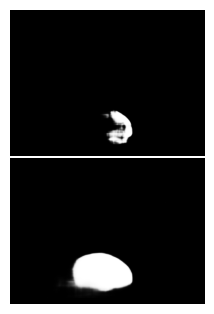

In [24]:
a = 79
# 创建紧凑画布
fig = plt.figure(figsize=(6, 3))

# 使用GridSpec控制微小边距
gs = fig.add_gridspec(2, 1, 
                     hspace=0.02,  # 行间距
                     left=0.01,    # 左边距
                     right=0.99,   # 右边距
                     top=0.99,     # 上边距
                     bottom=0.01)  # 下边距

# 添加图像子图
ax1 = fig.add_subplot(gs[0])
ax1.imshow(imgp[a].reshape(288, 384), 'gray')
ax1.axis('off')
ax1.margins(0.01)  # 图像周围微小边距

ax2 = fig.add_subplot(gs[1])
ax2.imshow(imgp1[a].reshape(288, 384), 'gray')
ax2.axis('off')
ax2.margins(0.01)  # 图像周围微小边距

# 显示紧凑布局
plt.show()